In [1]:
import numpy as np
import h5py
import time
import pandas as pd
import math
import scipy.misc
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def get_2D_data_from_h5_filtered_np_xy_changed(h5_path, part_name, slice_name, show_info = False):
    # opening h5 and getting the data
    start_time = time.time()

    with h5py.File(h5_path, 'r') as h5:
        # check whether slice exists -> if not: empty array returned
        # here the X and Y axis are changed to fit the OpenCV coordinate system
        
        if slice_name in h5[part_name]:
            X_Axis = np.array(h5[part_name][slice_name]['Y-Axis'][:]).astype(int)
            Area = np.array(h5[part_name][slice_name]['Area'][:]).astype(int)
            Intensity = np.array(h5[part_name][slice_name]['Intensity'][:]).astype(int)
            Y_Axis = np.array(h5[part_name][slice_name]['X-Axis'][:]).astype(int)

            X_Axis_size = X_Axis.size
            Y_Axis_size = Y_Axis.size
            Area_size = Area.size
            Intensity_size = Intensity.size

            # if dimensions aren't equal the following code block is entered
            if not X_Axis_size == Y_Axis_size == Area_size == Intensity_size:

                # determine the lowest value among the different sizes
                size_arr = np.array([X_Axis_size, Y_Axis_size, Area_size, Intensity_size])
                min_size = size_arr.min()

                if X_Axis_size != min_size:
                    diff_size_x = X_Axis_size - min_size  # calculating the difference between the actual value and the minimum and substracting it from the array
                    X_Axis_new = np.delete(X_Axis, -diff_size_x)
                    X_Axis = X_Axis_new
                    X_Axis_size = X_Axis.size

                if Y_Axis_size != min_size:
                    diff_size_y = Y_Axis_size - min_size
                    Y_Axis_new = np.delete(Y_Axis, -diff_size_y)
                    Y_Axis = Y_Axis_new
                    Y_Axis_size = Y_Axis.size

                if Area_size != min_size:
                    diff_size_area = Area_size - min_size
                    Area_new = np.delete(Area, -diff_size_area)
                    Area = Area_new
                    Area_size = Area.size

                if Intensity_size != min_size:
                    diff_size_intensity = Intensity_size - min_size
                    Intensity_new = np.delete(Intensity, -diff_size_intensity)
                    Intensity = Intensity_new
                    Intensity_size = Intensity.size

                # by reducing all the dimensions to the minimum equal dimensions are guaranteed
                # there is a risk of deleting more than just one datapoint without noticing -> maybe add an alert after more than 5(?) while iterations
            #

            if show_info:
                print(str(X_Axis_size) + ' total data points found')

            combos = np.stack((X_Axis, Y_Axis, Area, Intensity), axis=-1)

            # filtering out the outlier data points
            median_x = np.median(combos[:, 0])
            median_y = np.median(combos[:, 1])
            std_x = int(combos[:, 0].std())
            std_y = int(combos[:, 1].std())
            low_limit_x = median_x - 2 * std_x
            low_limit_y = median_y - 2 * std_y
            high_limit_x = median_x + 2 * std_x
            high_limit_y = median_y + 2 * std_y

            combos = np.delete(combos, np.where(combos[:, 0] < low_limit_x), axis=0)
            combos = np.delete(combos, np.where(combos[:, 0] > high_limit_x), axis=0)
            combos = np.delete(combos, np.where(combos[:, 1] < low_limit_y), axis=0)
            combos = np.delete(combos, np.where(combos[:, 1] > high_limit_y), axis=0)

            # filtering out the data points where area and intensity are =0
            area_zeros = np.where(combos[:, 2] == 0)
            intensity_zeros = np.where(combos[:, 3] == 0)
            zero_area_intensity_indices = np.intersect1d(area_zeros,
                                                         intensity_zeros)  # array of indices where area AND intensity are = 0

            # deleting all the datapoints where area AND intensity are = 0
            combos_wo_only_zeros = np.delete(combos, zero_area_intensity_indices, axis=0)
            if show_info:
                print(str(combos_wo_only_zeros.shape[0]) + ' data points where area != 0 AND intensity != 0')

            combos_wo_only_zeros_unique, unique_indices = np.unique(combos_wo_only_zeros[:, [0, 1]], axis=0,
                                                                    return_index=True)
            combos_unique = combos_wo_only_zeros[unique_indices]

            if show_info:
                print(str(combos_unique.shape[0]) + ' unique data points where area != 0 AND intensity != 0')

            Index_range = np.arange(combos_wo_only_zeros.shape[0])
            indices_of_interest = np.setdiff1d(Index_range,
                                               unique_indices)  # all the indices belonging to non unique x,y-combinations

            combo_processed_array = np.empty([0, 4], dtype=int)
            start_time = time.time()
            combos_wo_only_zeros_copy = np.copy(combos_wo_only_zeros)
            index_counter = 0
            shape_counter = 0
            indices_list = []

            if show_info:
                print("vor iterieren %s seconds ---" % (time.time() - start_time))

            for index in indices_of_interest:
                xy_combo = combos_wo_only_zeros[:, [0, 1]][index]
                if \
                np.where((combo_processed_array[:, 0] == xy_combo[0]) * (combo_processed_array[:, 1] == xy_combo[1]))[
                    0].size == 0:
                    index_counter += 1
                    xy_combo = combos_wo_only_zeros[:, [0, 1]][index]
                    indices_relevant = \
                    np.where((combos_wo_only_zeros[:, 0] == xy_combo[0]) * (combos_wo_only_zeros[:, 1] == xy_combo[1]))[
                        0]
                    max_area_of_combo = np.amax(combos_wo_only_zeros[:, 2][indices_relevant])
                    max_intensity_of_combo = np.amax(combos_wo_only_zeros[:, 3][indices_relevant])

                    max_combos = np.stack((xy_combo[0], xy_combo[1], max_area_of_combo, max_intensity_of_combo),
                                          axis=-1)

                    combos_wo_only_zeros_copy = np.vstack((combos_wo_only_zeros_copy, max_combos))
                    shape_counter += indices_relevant.shape[0]
                    indices_list.append(list(indices_relevant))

                    combo_processed_array = np.vstack((combo_processed_array, max_combos))

            indices_relevant = np.hstack(indices_list)
            combos_wo_only_zeros_copy = np.delete(combos_wo_only_zeros_copy, indices_relevant, axis=0)
        else:
            combos_wo_only_zeros_copy = np.empty([0, 4], dtype=int)
            print('{} is not existing -> empty array created'.format(slice_name))

        if show_info:
            print("array creation took %s seconds ---" % (time.time() - start_time))
        return combos_wo_only_zeros_copy

    
    
    




def dock_array_to_zero(array, minX, minY):
    if minX >= 0 and minY >= 0:
        array[:, 0] = array[:, 0] - minX
        array[:, 1] = array[:, 1] - minY
    elif minX < 0 and minY < 0:
        array[:, 0] = array[:, 0] + abs(minX)
        array[:, 1] = array[:, 1] + abs(minY)
    elif minX >= 0 and minY < 0:
        array[:, 0] = array[:, 0] - minX
        array[:, 1] = array[:, 1] + abs(minY)
    elif minX < 0 and minY >= 0:
        array[:, 0] = array[:, 0] + abs(minX)
        array[:, 1] = array[:, 1] - minY
    return array


def get_number_grid (length_x_part, length_y_part, grid_size):
    n_voxels_x = math.ceil(int(length_x_part)/grid_size)
    n_voxels_y = math.ceil(int(length_y_part)/grid_size)
    
    return n_voxels_x, n_voxels_y 


def create_single_grid_array_storage_reduced_coordsys_left_upper_corner (cur_n_grid_x, cur_n_grid_y, grid_size, array, y_max):
    
    #the added y_max - operation changes the coordinate system to a top left corner rotated coordinate system which is used by opencv
    #y_max = array[:,1].max()
    x_min_grid = cur_n_grid_x * grid_size
    x_max_grid = (cur_n_grid_x + 1)*grid_size
    y_min_grid = y_max-(cur_n_grid_y + 1) * grid_size
    y_max_grid = y_max-cur_n_grid_y * grid_size
    
    #print(x_min_grid)
    #print(x_max_grid)
    #print(y_min_grid)
    #print(y_max_grid)

    #x_axis_voxel =  np.repeat(np.arange(x_min_grid,x_max_grid,1),grid_size)
    #y_axis_voxel =  np.tile(np.arange(y_min_grid,y_max_grid,1),grid_size)
    #Zero_array = np.zeros(grid_size*grid_size, dtype=int)

    grid_array = np.empty([0,4],dtype= int)

    #check if datapoints in array are in the region of the voxel
    indices_relevant = np.where((array[:,0] >= x_min_grid)*(array[:,0] < x_max_grid)*(array[:,1] >= y_min_grid)*(array[:,1] < y_max_grid))[0]

    if indices_relevant.size != 0:
        relevant_array = array[indices_relevant]
        relevant_array[:,0] = relevant_array[:,0] - x_min_grid
        relevant_array[:,1] = relevant_array[:,1] - y_min_grid

        final_grid_array = relevant_array
    else:
        final_grid_array = grid_array

    return final_grid_array



def process_data_to_picturelike_structure(array, grid_size, kernel_size, max_int):
    # creating a picture grid with only zeros as a base for data filling
    picture_grid = np.zeros((grid_size, grid_size), dtype=np.uint8)
    
    # filling in the points from final grid, row[3]
    for row in array:    
        picture_grid[row[0],row[1]] = int(row[3]*255/max_int)
        
    return  ndimage.grey_dilation(picture_grid, size=(kernel_size, kernel_size))


def get_max_intensity_whole_part(h5_path, part_name,  max_slice_num):
    df = pd.DataFrame(columns=['Slice_num', 'maxInt', 'medianInt', 'meanInt', 'StdInt'])

    for num_slice in range(max_slice_num):
        slice_name = 'Slice' + str("{:05d}".format(num_slice + 1))

        array = get_2D_data_from_h5_filtered_np_xy_changed(h5_path, part_name, slice_name)
        maxInt = array[:, 3].max()
        medianInt = np.median(array[:, 3])
        meanInt = np.mean(array[:, 3])
        stdInt = np.std(array[:, 3])
        
        df = df.append({'Slice_num': "{:05d}".format(num_slice + 1), 'maxInt': maxInt, 'medianInt':medianInt, 'meanInt':meanInt, 'StdInt':stdInt}, ignore_index=True)

    return df['medianInt'].mean(), df['StdInt'].mean()


def filter_out_outlier_intensity(array, n_sigma, median_int, std_int):
    low_limit_int = int(median_int - n_sigma * std_int)
    high_limit_int = int(median_int + n_sigma * std_int)

    array_return = np.delete(array, np.where(array[:, 3] < low_limit_int), axis=0)
    array_return = np.delete(array, np.where(array[:, 3] > high_limit_int), axis=0)
        
    return array_return, high_limit_int

In [3]:
ZP_nummer = 1
min_slice = 381
max_slice = 1551
h5_path = '/home/jan/Documents/Trainingsdaten/ZPs/ZP{}/ZP_{}_full_part.h5'.format(ZP_nummer, ZP_nummer)
part_name = 'ZP{}_combined'.format(ZP_nummer)
slice_name = "Slice00001"
grid_size = 874
kernel_size = 10
stds = 5

In [4]:
# changed so it returns dataframe for investigation of abnormality of max/min values of ZP3 


def get_min_max_values_xy_changed (h5_path, part_name,  max_slice_num):
    df = pd.DataFrame(columns=['Slice_num', 'minX', 'maxX', 'minY', 'maxY', 'diameterX', 'diameterY'])

    for num_slice in range(max_slice_num):
        slice_name = 'Slice' + str("{:05d}".format(num_slice + 1))

        array = get_2D_data_from_h5_filtered_np_xy_changed(h5_path, part_name, slice_name)
        minX = array[:, 0].min()
        maxX = array[:, 0].max()
        minY = array[:, 1].min()
        maxY = array[:, 1].max()
        diameterX = maxX - minX
        diameterY = maxY - minY

        df = df.append({'Slice_num': "{:05d}".format(num_slice + 1), 'minX': minX, 'maxX': maxX, 'minY': minY, 'maxY': maxY,
                        'diameterX': diameterX, 'diameterY': diameterY}, ignore_index=True)

    return df, df['minX'].min(), df['minY'].min(), df['maxX'].max(), df['maxY'].max()

In [5]:
df, minX, minY, maxX, maxY = get_min_max_values_xy_changed (h5_path, part_name,  1593)
y_max = maxY-minY
length_x_part = maxX - minX
length_y_part = maxY - minY

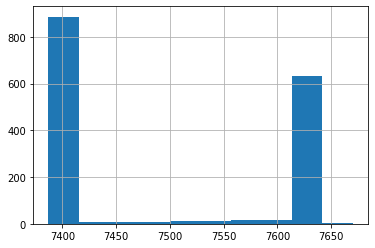

In [6]:
df['minX'].hist()

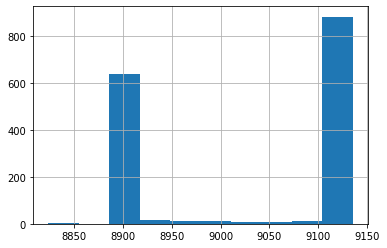

In [7]:
df['maxX'].hist()

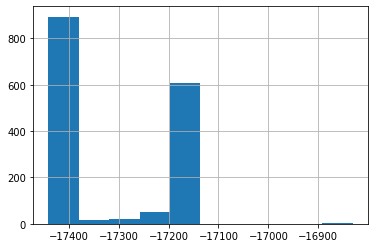

In [8]:
df['minY'].hist()

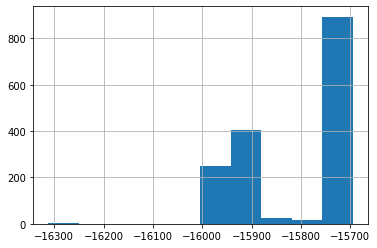

In [9]:
df['maxY'].hist()